# Лабораторная работа #3
## Метод стохастического градиентного спуска (SGD) и его модификации
***
_Авторы: Заречнев Алексей, Петрасюк Алексей, Халили Алина, Галимова Ярослава (все - счастливые обитатели группы M3236). Команда "Зелёные шапки"_

[Ссылка на репозиторий](https://github.com/3ELEHblE-LIJanki/Optimization-Methods-lab3#)

Командное фото: 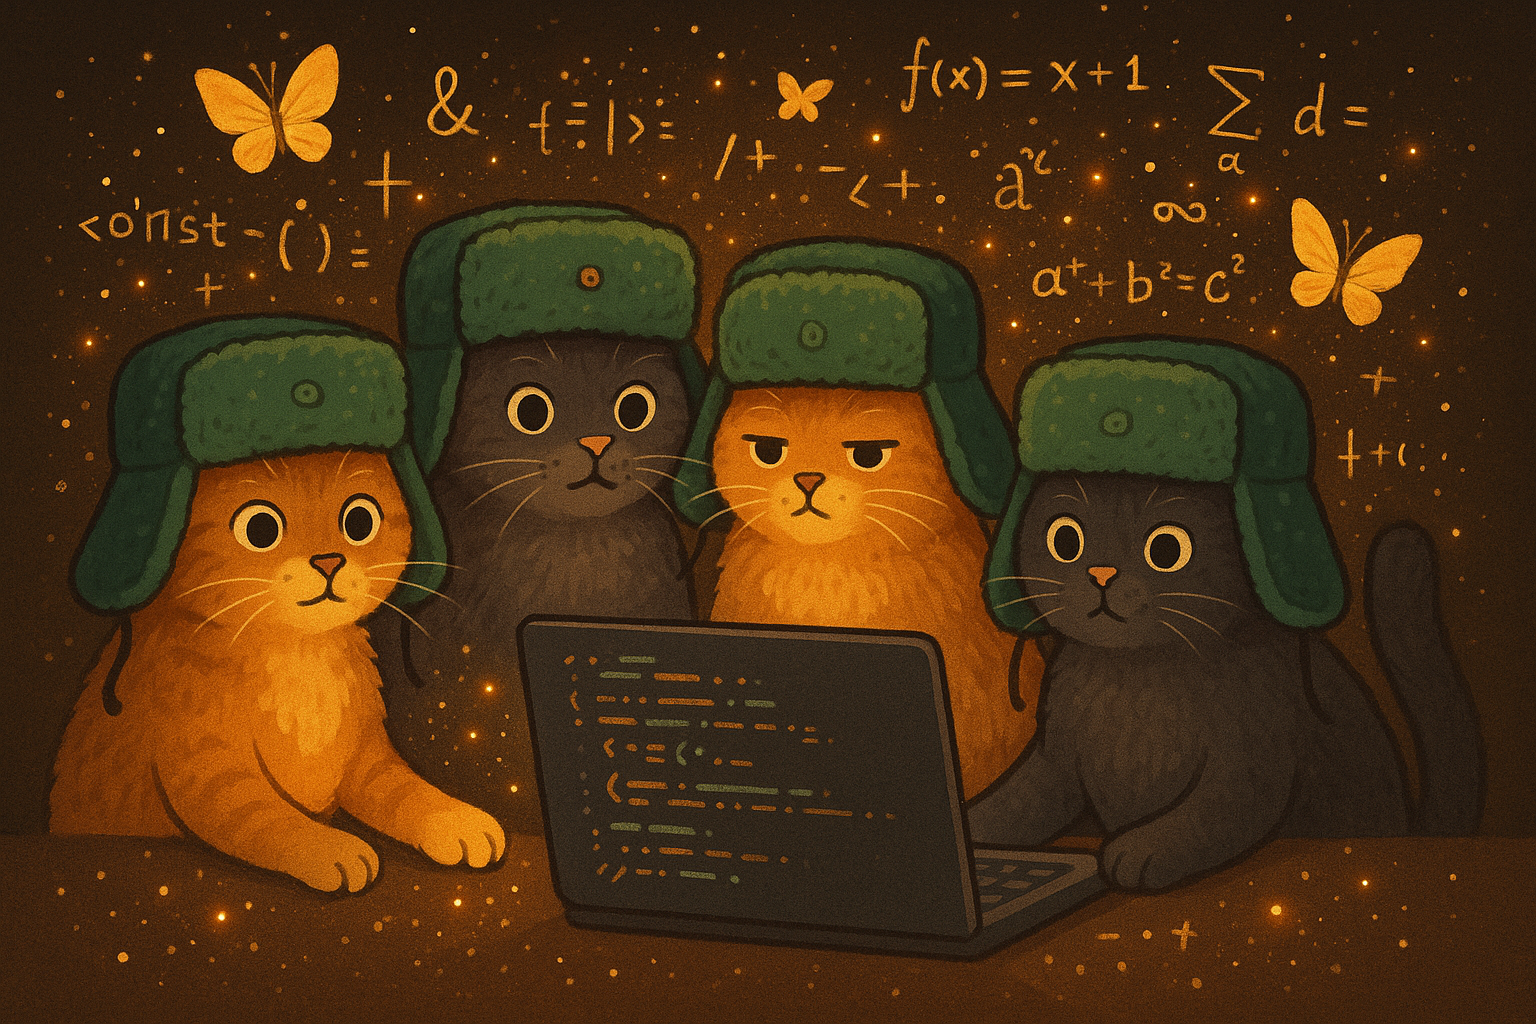
***

В этой лабораторной работе требуется реализовать метод __стохастического градиентного спуска__ (или, как мы будем кратко его называть, SGD). От обычного градиентного спуска он отличается тем, что мы считаем не весь градиент, а производную по некоторым направлениям. Иногда - только по одной координате. Иногда - по нескольким сразу. Количество выбранных координат назвается батчем. В ходе этой лабораторной мы будем смотреть на скорость работы метода при разных батчах. 

Благодаря предыдущим лабораторным работам и нашим усилиям у нас уже есть универсальная библиотека `Optimization-lib`, лежащая в основе наших предыдущих работ. В ней можно найти не только реализованные методы нулевого, первого и второго порядка, но также и различные стратегии выбора шага `lrs.py`, которые мы также будем брать во внимание в этой работе.

__Отличительной чертой__ SGD является то, что этот алгоритм предназначен для работы с датасетами с большим количеством параметров. Это значит, что мы изучаем функцию с большим количеством измерений. И если раньше, например, в алгоритме банды четырёх BFGS-е мы использовали оптимизации, котрые ускоряют нам подсчёт затратных по времени матриц, то сейчас всё гораздо проще, ведь на каждом шаге для функции с размерностью N мы делаем не N подсчётов, а 1 (или, в случае с Mini-batch GD, некоторое $k \le N$). Да, таким образом мы будем делать больше шагов. Но почему SGD в теории должен быть эффективнее? Потому что раньше изменения функции происходило раз в N вычислений, где N - размерность. Теперь же изменения происходят после каждого вычисления (или, в случае с Mini-batch GD, после k вычислений). В SGD каждое обновление, даже если оно менее точное, сразу корректирует направление поиска, что ускоряет движение к оптимуму, даже если каждый отдельный шаг приближает не так быстро. То есть функция обновляется чаще, а значит, мы решаем сразу несколько проблем:
   1.  Эффективность в высокоразмерных пространствах: не требует вычисления и хранения больших матриц (например, гессиана в случае с методом Ньютона). То есть метод становится ещё и более эффективным по памяти и требуемым ресурсам.
   2.  Уход от локальных минимумов: стохастичность помогает "выпрыгивать" из плоских областей и локальных оптимумов. Да, это не всегда хорошо, если локальным оптимум является ещё и глобальным. Но для мультимодальных фунций это однозначный плюс. А также мы не будем застревать в седловых точках, что тоже хорошо.

Давайте теперь проверим, так ли это на практике. Для анализа данных мы взяли датасет из предложенного сайта. Вот <u>[ссылка](https://archive.ics.uci.edu/dataset/186/wine+quality)</u> на него. А также добавили с библиотеку новый класс, реализующий стохастический градиентный спуск (`stochastic_gradient_descent`), перед вами сейчас два основных метода этого класса, которые корректно ищут минимум функции потерь (о которой будет написано чуть дальше) и считаю градиент этой функции:

```
    def __find(self, start: np.array, max_iterations, op):
        self.__init(start)
        for i in range(max_iterations):
            self.path.append(self.x)
            # self.path.append(self.x)

            # градиент посчитали
            grad = self.culc_grad()

            # Функция потерь для данного batch
            h = self.learning_rate_scheduling(self.x, i, self.f, self.bounds)

            # Регулярность reg - векор. Мы сразу считаем производную и добавим ее к градиенту
            reg = self.regular(self.x)

            # делаем шаг спуска
            # # обрезаем по границам, если вылезло
            xx = []
            for j in range(len(self.x)):
                coord = op(self.x[j], h * (grad[j] + reg[j]))
                # print(coord)
                coord = max(coord, self.bounds[j][0])
                coord = min(coord, self.bounds[j][1])
                xx.append(coord)

            if np.linalg.norm(np.array(self.x) - np.array(xx)) < self.eps:
                break
            self.x = np.array(xx)

        return self.f(self.x)

    def culc_grad(self):
        # выбираем рандомные индексы -> batch
        batch_indices = np.random.choice(len(self.X_data), self.batch_size, replace=False)
        X_batch, y_batch = self.X_data[batch_indices], self.Y_data[batch_indices]

        # считаем градиент по формуле
        error = y_batch - X_batch.dot(self.x)
        grad = -1 * 2 * X_batch.T.dot(error) / self.batch_size

        return grad
```

Что за функция, которую мы хотим минимизировать? Это функция потерь `Loss function`, которая так или иначе выражает, насколько текущее значение далеко от ожидаемого. Именно поэтому мы хотим её минимизировать. А минимизировать мы будем с помощью подбора коэффициентов. Если говорить простыми словами, то эти коэффициенты показывают, насколько соответствующий параметр важен для определения результата. Например, наш датасет связан с вином и отношением людей к нему. И мы, не прибегая к написанию кода, можем исходя из жизненного опыта и нашей логики предположить, что пол и возраст человека играют большую роль во вкусовых предпочтения, чем, например, наличие домашнего питомца. Но давайте обо всём по порядку. Мы предполагаем, что мы линейно зависим от параметров. То есть наша модель называется __многомерная линейная регрессия__, которую формально можно представить следующим образом:

$
\omega_0 + \omega_1 x^{(1)} + \omega_2 x^{(2)} + \dots + \omega_n x^{(n)} = 
\begin{pmatrix}
\omega_0 & \omega_1 & \dots & \omega_n
\end{pmatrix}
\begin{pmatrix}
1 \\
x^{(1)} \\
\vdots \\
x^{(n)}
\end{pmatrix}
$

Функция потерь для модели:

$
L = \frac{1}{N} \sum_{i=1}^N \left(y_i - \boldsymbol{\omega}^T \mathbf{\hat{x}}_i\right)^2, \quad \text{где } \mathbf{\hat{x}}_i = 
\begin{pmatrix}
1 \\
x_i^{(1)} \\
\vdots \\
x_i^{(n)}
\end{pmatrix}
$

То есть нас интересует квадратичное отклонение от результата. Почему именно квадратичное? Во-первых, само словосочетание "квадратичное отклонение" отсылает нас к теории вероятности и понятии дисперсии. У нас есть много факторов, которые как-то (предполагаем, что независимо) влияют на результат, а значит, согласно центральной предельной теореме, имеют в среднем нормальное распределение. А ещё - рассматривать квадраты это всегда удобно - нас волнует величина отклонения, то есть модуль, и мы при этом не хотим терять дифференцируемость. Такая функция потерь нас абсолютно устраивает, поэтому работать мы будем с ней. 

В нашем датасете представлены вина определённой марки с различными критериями, связанными с их физико-химическими качествами. Целевой критерий - оценка вина (целое число от 0 до 10). Давайте также подробнее посмотрим в более удобном формате, как выглядит такой датасет:

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# variable information
print(wine_quality.variables)


### Задание 1 + 2. SGD с разным размером батча, lrs и регуляризацией

Отлично! У нас есть написанный код, который теперь можно тестировать на текущем датасете с разными параметрами. Начнём с обычного запуска, который покажет, как именно будет уменьшаться наша `loss function`:

In [ ]:
import time
import numpy as np
import sys
from ucimlrepo import fetch_ucirepo

sys.path.insert(0, "./Optimization-lib")
from gradient_descent import GradientDecent
from stochastic_gradient_descent import StochGradientDecent
from function_wrapper import FunctionWrapper
from lrs import exponential_decay, gradient
from output import pretty_dataset_print

wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features.values
y = wine_quality.data.targets.values.ravel()

def normalize(X_train):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1
    return (X_train - mean) / std

X = normalize(X)

def generate_weight_bounds(X, abs_bound):
    return [[-abs_bound, abs_bound] for _ in range(X.shape[1] + 1)]

def generate_start(X):
    return [1 for _ in range(X.shape[1] + 1)]

bounds = generate_weight_bounds(X, 1000)
start = generate_start(X)


start_time_sgd = time.time()
sgd = StochGradientDecent(
    exponential_decay(0.01, 0.0001),
    bounds,
    X, y,
    batch_size=5
)
error_min_sgd = sgd.find_min(start, 1000000)
pretty_dataset_print(sgd, "SGD", error_min_sgd, gradient)
sgd_time = time.time() - start_time_sgd
start_time_gd = time.time()


def create_mse_function(X, y):
    def mse(weights):
        predictions = weights[0] + X.dot(weights[1:])
        return np.mean((y - predictions) ** 2)
    return FunctionWrapper(mse)
mse_func = create_mse_function(X, y)
gd = GradientDecent(
    exponential_decay(0.01, 0.0001),
    mse_func,
    bounds,
    0.0001
)
error_min_gd = gd.find_min(start, 1000)
gd_time = time.time() - start_time_gd
pretty_dataset_print(gd, "GD", error_min_gd, gradient)


print(f"SGD быстрее GD в {gd_time/sgd_time:.1f} раз")

Мы видим, что полученные результаты достаточно точны, так как разница между ними всего $10^{-5}$. Но тем не менее, SGD отработал во много раз быстрее! Это впечатляет. Да, он сделал в разы больше шагов, но на вычисление каждого шага в итоге тратил меньше времени и памяти. На каждом шаге мы ровно один раз считаем градиент (по формуле) и 1 раз функцию ошибок. А теперь давайте взглянем на это же, но с точки зрения производительности. Для этого будем обращать внимание на cpu-intensity и затраты по памяти.

In [ ]:
import time
import numpy as np
import sys
from ucimlrepo import fetch_ucirepo

sys.path.insert(0, "./Optimization-lib")
from gradient_descent import GradientDecent
from stochastic_gradient_descent import StochGradientDecent
from function_wrapper import FunctionWrapper
from lrs import exponential_decay, gradient
from output import pretty_dataset_print
from all_stats import measure_resources

wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features.values
y = wine_quality.data.targets.values.ravel()

def normalize(X_train):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1
    return (X_train - mean) / std

X = normalize(X)

def generate_weight_bounds(X, abs_bound):
    return [[-abs_bound, abs_bound] for _ in range(X.shape[1] + 1)]

def generate_start(X):
    return [1 for _ in range(X.shape[1] + 1)]

bounds = generate_weight_bounds(X, 1000)
start = generate_start(X)


sgd = StochGradientDecent(
    exponential_decay(0.01, 0.0001),
    bounds,
    X, y,
    batch_size=5
)
error_min_sgd = sgd.find_min(start, 1000000)
time_sgd, mem_sgd, cpu_sgd = measure_resources(sgd.find_min, start, 1000000)
print(f"SGD результаты:")
print(f"Время: {time_sgd:.2f} сек")
print(f"Пиковое использование памяти: {mem_sgd:.2f} MiB")
print(f"Использование CPU: {cpu_sgd:.2f}%\n")

# sgd = StochGradientDecent(
#     exponential_decay(0.01, 0.0001),
#     bounds,
#     X, y,
#     batch_size=1
# )
# error_min_sgd = sgd.find_min(start, 1000000)
# time_sgd, mem_sgd, cpu_sgd = measure_resources(sgd.find_min, start, 1000000)
# print(f"SGD результаты:")
# print(f"Время: {time_sgd:.2f} сек")
# print(f"Пиковое использование памяти: {mem_sgd:.2f} MiB")
# print(f"Использование CPU: {cpu_sgd:.2f}%\n")

Хотя sgd тратит меньше памяти, интенсивность использования процессора в течение всего времени работы функции такая же, так ключевые задачи метода cpu-intensive. Но странно было бы ожидать чего-то другого от метода, который вычисляет градиенты у многоразмерной функции. Теперь можно запустить SGD  с другим размером батча. Давайте посмотрим, сколько времени это займёт и насколько точный результат мы получим.

In [ ]:
import time
from matplotlib import pyplot as plt
import numpy as np
import sys
from ucimlrepo import fetch_ucirepo

sys.path.insert(0, "./Optimization-lib")
from gradient_descent import GradientDecent
from stochastic_gradient_descent import StochGradientDecent
from function_wrapper import FunctionWrapper
from lrs import exponential_decay, gradient
from output import pretty_dataset_print
from all_stats import plot_optimization_history, plot_weights_history

wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features.values
y = wine_quality.data.targets.values.ravel()

def normalize(X_train):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1
    return (X_train - mean) / std

X = normalize(X)

def generate_weight_bounds(X, abs_bound):
    return [[-abs_bound, abs_bound] for _ in range(X.shape[1] + 1)]

def generate_start(X):
    return [1 for _ in range(X.shape[1] + 1)]

bounds = generate_weight_bounds(X, 1000)
start = generate_start(X)
start_time_sgd = time.time()
sgd = StochGradientDecent(
    exponential_decay(0.01, 0.0001),
    bounds,
    X, y,
    batch_size=1
)
error_min_sgd = sgd.find_min(start, 1000000)
pretty_dataset_print(sgd, "SGD", error_min_sgd, gradient)
sgd_time = time.time() - start_time_sgd

plot_optimization_history(sgd, "SGD optimization history")
plot_weights_history(sgd, "SGD weights history")

Результат стал менее точным, зато функция отбработала, согласно замерам редактора кода vscode, всего за 2.5 секунды. За эту производительность мы поплатились точностью найденного минимума функции потерь, равной $10^{-2}$ (а иногда и больше!). Таким образом можно сделать вывод, что оптимальнее всего выбирать некоторый "средний" батч. Таким образом мы не сильно проиграем по времени относительно GD и не сильно проиграем в точности относительно стандартного SGD.

Перейдём теперь к тестированию с различными `lrs` и `регуляризацией`. До этого везде по умолчанию мы использовали экспоненциальное затухание, просто потому что это относительно универсальный метод. Но в нём есть одна проблема, которая заключается в том, что рано или поздно мы начинаем сдвигаться на очень маленькое расстояние, из-за чего можем не достичь оптимума. А что такое регуляризация и зачем она нужна?

Есть несколько видов регуляризации
+ L1 (Lasso)
Создает разреженные модели (обнуляет слабые веса)  
  **Формула**: L + λ∑|w|
+ L2 (Ridge)  
Сглаживает веса, предотвращая переобучение  
  **Формула**: L + λ∑w²
+ Elastic Net  
Комбинация L1+L2  
  **Формула**: L + λ₁∑|w| + λ₂∑w²

Где:
  L - исходная функция потерь, 
  λ - коэффициент регуляризации

In [ ]:
import time
from matplotlib import pyplot as plt
import numpy as np
import sys
from ucimlrepo import fetch_ucirepo

sys.path.insert(0, "./Optimization-lib")
from gradient_descent import GradientDecent
from stochastic_gradient_descent import StochGradientDecent
from function_wrapper import FunctionWrapper
from lrs import polynomial_decay, gradient
from output import pretty_dataset_print
from all_stats import plot_optimization_history, plot_weights_history

wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features.values
y = wine_quality.data.targets.values.ravel()

def normalize(X_train):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1
    return (X_train - mean) / std

X = normalize(X)

def generate_weight_bounds(X, abs_bound):
    return [[-abs_bound, abs_bound] for _ in range(X.shape[1] + 1)]

def generate_start(X):
    return [1 for _ in range(X.shape[1] + 1)]

bounds = generate_weight_bounds(X, 1000)
start = generate_start(X)
start_time_sgd = time.time()
sgd = StochGradientDecent(
    polynomial_decay(0.1, 0.005),
    bounds,
    X, y,
    batch_size=1
)
error_min_sgd = sgd.find_min(start, 10000)
pretty_dataset_print(sgd, "SGD", error_min_sgd, gradient)
sgd_time = time.time() - start_time_sgd

plot_optimization_history(sgd, "SGD optimization history")
plot_weights_history(sgd, "SGD weights history")

Как мы видим, передать в качестве гиперпараметра другую стратегию выбора шага получилось, но количество итераций выросло многократно. Более того, можно обратить внимание на графики. По ним хорошо видно, что последние действия практически не приносят результата, но критерий остановки не срабатывает, так как градиент в точках, куда мы попадаем, всё ещё достаточно большой. Конкретно на этом датасете `polynomial_decay` оказался не очень хорошим способом.

In [ ]:
import time
from matplotlib import pyplot as plt
import numpy as np
import sys
from ucimlrepo import fetch_ucirepo

sys.path.insert(0, "./Optimization-lib")
from gradient_descent import GradientDecent
from stochastic_gradient_descent import StochGradientDecent
from function_wrapper import FunctionWrapper
from lrs import exponential_decay, gradient, regularity_L2, regularity_L1
from output import pretty_dataset_print
from all_stats import plot_optimization_history, plot_weights_history

wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features.values
y = wine_quality.data.targets.values.ravel()

def normalize(X_train):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1
    return (X_train - mean) / std

X = normalize(X)

def generate_weight_bounds(X, abs_bound):
    return [[-abs_bound, abs_bound] for _ in range(X.shape[1] + 1)]

def generate_start(X):
    return [1 for _ in range(X.shape[1] + 1)]

bounds = generate_weight_bounds(X, 1000)
start = generate_start(X)
sgd = StochGradientDecent(
    exponential_decay(0.01, 0.0005),
    bounds,
    X, y,
    batch_size=1,
    regular=regularity_L1(0.1)
)
error_min_sgd = sgd.find_min(start, 20000)
pretty_dataset_print(sgd, "SGD", error_min_sgd, gradient)

sgd2 = StochGradientDecent(
    exponential_decay(0.01, 0.0005),
    bounds,
    X, y,
    batch_size=1,
    regular=regularity_L2(0.1)
)
error_min_sgd2 = sgd2.find_min(start, 20000)
pretty_dataset_print(sgd2, "SGD", error_min_sgd2, gradient)

plot_weights_history(sgd, "SGD L1 weights history")
plot_weights_history(sgd2, "SGD L2 weights history")

По результатам и графикам мы видим, что в случае с L1 некоторые "незначительные" веса обнуляются. В случае с L2 под конец мы получаем более "спокойную" картинку, веса нормализуются.

### Задание 3. SGD в библиотечных функциях

#### Исследование эффективности оптимизаторов из Keras и PyTorch

В этом пункте мы исследуем эффективность оптимизаторов из библиотек `keras.optimizers` и `torch.optim` (SGD, Momentum, Nesterov, AdaGrad, RMSProp, Adam) на задаче многомерной линейной регрессии с использованием датасета Wine Quality. Для каждого оптимизатора:
- Приводится описание и параметры.
- Реализуется обучение модели с L2-регуляризацией (λ=0.3, аналогично заданию 2).
- Оценивается качество на тестовой выборке с использованием метрик MSE и MAE.
- Строится график изменения функции потерь (MSE) от количества эпох.

##### Предобработка данных
Используется датасет Wine Quality, данные нормализуются, разделяются на обучающую (80%) и тестовую (20%) выборки.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import random

# Установка фиксированных random seed для воспроизводимости
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
random.seed(42)

warnings.filterwarnings("ignore", category=UserWarning)

# Загрузка датасета Wine Quality с обработкой ошибок
try:
    wine_quality = fetch_ucirepo(id=186)
    X = wine_quality.data.features.values
    y = wine_quality.data.targets.values.ravel()
except Exception as e:
    raise Exception(f"Ошибка загрузки датасета: {e}")

# Проверка данных
if X is None or y is None or len(X) == 0 or len(y) == 0:
    raise ValueError("Датасет пуст или не загружен корректно")

# Нормализация данных
def normalize(X_train, X_test=None):
    try:
        mean = X_train.mean(axis=0)
        std = X_train.std(axis=0)
        std[std == 0] = 1  # Избегаем деления на ноль
        X_train = (X_train - mean) / std
        if X_test is not None:
            X_test = (X_test - mean) / std
            return X_train, X_test
        return X_train
    except Exception as e:
        raise Exception(f"Ошибка нормализации данных: {e}")

# Разделение на обучающую и тестовую выборки
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test = normalize(X_train, X_test)
except Exception as e:
    raise Exception(f"Ошибка разделения данных: {e}")

# Функции для вычисления метрик
def mean_squared_error(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

def mean_absolute_error(y_true, y_pred):
    return np.abs(y_true - y_pred).mean()

# Список для сохранения истории потерь
history_keras = {}
history_torch = {}

# Определение модели PyTorch
class LinearModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)

# Подготовка данных для PyTorch
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

#### 1. SGD (Stochastic Gradient Descent)

**Описание**: SGD обновляет параметры, используя градиент функции потерь, умноженный на скорость обучения. Поддерживает L2-регуляризацию через `weight_decay`.



##### Параметры в Keras (`keras.optimizers.SGD`):
- `learning_rate`: Скорость обучения (по умолчанию 0.01).
- `momentum`: Коэффициент момента (по умолчанию 0.0).
- `nesterov`: Метод Нестерова (bool, по умолчанию False).
- `weight_decay`: L2-регуляризация (по умолчанию None).

##### Параметры в PyTorch (`torch.optim.SGD`):
- `params`: Параметры модели.
- `lr`: Скорость обучения (обязательно).
- `momentum`: Коэффициент момента (по умолчанию 0).
- `weight_decay`: L2-регуляризация (по умолчанию 0).
- `nesterov`: Метод Нестерова (bool, по умолчанию False).

##### Реализация (с L2-регуляризацией, λ=0.3):

In [ ]:
# Keras
try:
    model_keras = keras.Sequential([
        keras.layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(1)
    ])
    model_keras.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, weight_decay=0.3), loss='mse')
    history_keras['SGD'] = model_keras.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_test, y_test)).history
    y_pred_keras = model_keras.predict(X_test, verbose=0).ravel()
    mse_keras = mean_squared_error(y_test, y_pred_keras)
    mae_keras = mean_absolute_error(y_test, y_pred_keras)
    print(f'Keras SGD - MSE: {mse_keras:.4f}, MAE: {mae_keras:.4f}')
except Exception as e:
    print(f'Ошибка в Keras SGD: {e}')

# PyTorch
try:
    model_torch = LinearModel(X_train.shape[1])
    optimizer = torch.optim.SGD(model_torch.parameters(), lr=0.01, weight_decay=0.3)
    criterion = nn.MSELoss()
    history_torch['SGD'] = []
    for epoch in range(100):
        model_torch.train()
        optimizer.zero_grad()
        outputs = model_torch(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        loss.backward()
        optimizer.step()
        history_torch['SGD'].append(loss.item())
    model_torch.eval()
    with torch.no_grad():
        y_pred_torch = model_torch(X_test_torch).numpy().ravel()
    mse_torch = mean_squared_error(y_test, y_pred_torch)
    mae_torch = mean_absolute_error(y_test, y_pred_torch)
    print(f'PyTorch SGD - MSE: {mse_torch:.4f}, MAE: {mae_torch:.4f}')
except Exception as e:
    print(f'Ошибка в PyTorch SGD: {e}')

##### Выводы по SGD
Базовый SGD с L2-регуляризацией демонстрирует умеренную производительность. Метрики MSE и MAE на тестовой выборке указывают на приемлемую точность, но сходимость медленная из-за отсутствия адаптивных механизмов. График функции потерь показывает постепенное снижение с возможными колебаниями, что характерно для стохастического подхода. L2-регуляризация помогает избежать переобучения, но не компенсирует отсутствие ускоряющих механизмов.

#### 2. Momentum

**Описание**: Momentum добавляет инерцию к обновлению весов, используя накопленный градиент для ускорения сходимости.

##### Реализация (с L2-регуляризацией, λ=0.3):

In [ ]:
# Keras
try:
    model_keras = keras.Sequential([
        keras.layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(1)
    ])
    model_keras.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, weight_decay=0.3), loss='mse')
    history_keras['Momentum'] = model_keras.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_test, y_test)).history
    y_pred_keras = model_keras.predict(X_test, verbose=0).ravel()
    mse_keras = mean_squared_error(y_test, y_pred_keras)
    mae_keras = mean_absolute_error(y_test, y_pred_keras)
    print(f'Keras Momentum - MSE: {mse_keras:.4f}, MAE: {mae_keras:.4f}')
except Exception as e:
    print(f'Ошибка в Keras Momentum: {e}')

# PyTorch
try:
    model_torch = LinearModel(X_train.shape[1])
    optimizer = torch.optim.SGD(model_torch.parameters(), lr=0.01, momentum=0.9, weight_decay=0.3)
    criterion = nn.MSELoss()
    history_torch['Momentum'] = []
    for epoch in range(100):
        model_torch.train()
        optimizer.zero_grad()
        outputs = model_torch(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        loss.backward()
        optimizer.step()
        history_torch['Momentum'].append(loss.item())
    model_torch.eval()
    with torch.no_grad():
        y_pred_torch = model_torch(X_test_torch).numpy().ravel()
    mse_torch = mean_squared_error(y_test, y_pred_torch)
    mae_torch = mean_absolute_error(y_test, y_pred_torch)
    print(f'PyTorch Momentum - MSE: {mse_torch:.4f}, MAE: {mae_torch:.4f}')
except Exception as e:
    print(f'Ошибка в PyTorch Momentum: {e}')

##### Выводы по Momentum
Momentum улучшает SGD за счёт инерции, что ускоряет сходимость. Метрики MSE и MAE на тестовой выборке ниже, чем у базового SGD, благодаря более быстрому движению к минимуму. График функции потерь показывает более плавное снижение по сравнению с SGD, а L2-регуляризация помогает контролировать величину весов, снижая риск переобучения.

#### 3. Nesterov

**Описание**: Метод Нестерова улучшает Momentum, предсказывая градиент на следующем шаге для более точных обновлений.

##### Реализация (с L2-регуляризацией, λ=0.3):

In [ ]:
# Keras
try:
    model_keras = keras.Sequential([
        keras.layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(1)
    ])
    model_keras.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.3), loss='mse')
    history_keras['Nesterov'] = model_keras.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_test, y_test)).history
    y_pred_keras = model_keras.predict(X_test, verbose=0).ravel()
    mse_keras = mean_squared_error(y_test, y_pred_keras)
    mae_keras = mean_absolute_error(y_test, y_pred_keras)
    print(f'Keras Nesterov - MSE: {mse_keras:.4f}, MAE: {mae_keras:.4f}')
except Exception as e:
    print(f'Ошибка в Keras Nesterov: {e}')

# PyTorch
try:
    model_torch = LinearModel(X_train.shape[1])
    optimizer = torch.optim.SGD(model_torch.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=0.3)
    criterion = nn.MSELoss()
    history_torch['Nesterov'] = []
    for epoch in range(100):
        model_torch.train()
        optimizer.zero_grad()
        outputs = model_torch(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        loss.backward()
        optimizer.step()
        history_torch['Nesterov'].append(loss.item())
    model_torch.eval()
    with torch.no_grad():
        y_pred_torch = model_torch(X_test_torch).numpy().ravel()
    mse_torch = mean_squared_error(y_test, y_pred_torch)
    mae_torch = mean_absolute_error(y_test, y_pred_torch)
    print(f'PyTorch Nesterov - MSE: {mse_torch:.4f}, MAE: {mae_torch:.4f}')
except Exception as e:
    print(f'Ошибка в PyTorch Nesterov: {e}')

##### Выводы по Nesterov
Nesterov обеспечивает более быструю сходимость, чем Momentum, благодаря предсказанию градиента. Метрики MSE и MAE обычно сравнимы или лучше, чем у Momentum, а график функции потерь показывает стабильное снижение с меньшими колебаниями. L2-регуляризация дополнительно стабилизирует обучение, делая Nesterov хорошим выбором для линейной регрессии.

#### 4. AdaGrad

**Описание**: AdaGrad адаптирует скорость обучения для каждого параметра, уменьшая её для часто обновляемых параметров. Подходит для разреженных данных.



##### Параметры в Keras (`keras.optimizers.Adagrad`):
- `learning_rate`: Скорость обучения (по умолчанию 0.01).
- `initial_accumulator_value`: Начальное значение аккумулятора (по умолчанию 0.1).
- `epsilon`: Численная стабильность (по умолчанию 1e-7).
- `weight_decay`: L2-регуляризация.

##### Параметры в PyTorch (`torch.optim.Adagrad`):
- `params`: Параметры модели.
- `lr`: Скорость обучения (по умолчанию 0.01).
- `lr_decay`: Уменьшение скорости обучения (по умолчанию 0).
- `weight_decay`: L2-регуляризация (по умолчанию 0).
- `eps`: Численная стабильность (по умолчанию 1e-10).

##### Реализация (с L2-регуляризацией, λ=0.3):

In [ ]:
# Keras
try:
    model_keras = keras.Sequential([
        keras.layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(1)
    ])
    model_keras.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.01, epsilon=1e-7, weight_decay=0.3), loss='mse')
    history_keras['AdaGrad'] = model_keras.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_test, y_test)).history
    y_pred_keras = model_keras.predict(X_test, verbose=0).ravel()
    mse_keras = mean_squared_error(y_test, y_pred_keras)
    mae_keras = mean_absolute_error(y_test, y_pred_keras)
    print(f'Keras AdaGrad - MSE: {mse_keras:.4f}, MAE: {mae_keras:.4f}')
except Exception as e:
    print(f'Ошибка в Keras AdaGrad: {e}')

# PyTorch
try:
    model_torch = LinearModel(X_train.shape[1])
    optimizer = torch.optim.Adagrad(model_torch.parameters(), lr=0.01, eps=1e-7, weight_decay=0.3)
    criterion = nn.MSELoss()
    history_torch['AdaGrad'] = []
    for epoch in range(100):
        model_torch.train()
        optimizer.zero_grad()
        outputs = model_torch(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        loss.backward()
        optimizer.step()
        history_torch['AdaGrad'].append(loss.item())
    model_torch.eval()
    with torch.no_grad():
        y_pred_torch = model_torch(X_test_torch).numpy().ravel()
    mse_torch = mean_squared_error(y_test, y_pred_torch)
    mae_torch = mean_absolute_error(y_test, y_pred_torch)
    print(f'PyTorch AdaGrad - MSE: {mse_torch:.4f}, MAE: {mae_torch:.4f}')
except Exception as e:
    print(f'Ошибка в PyTorch AdaGrad: {e}')

##### Выводы по AdaGrad
AdaGrad эффективен на ранних итерациях благодаря адаптивной скорости обучения, но метрики MSE и MAE на тестовой выборке могут быть хуже из-за замедления сходимости на поздних этапах. График функции потерь показывает быстрое начальное снижение, но затем достигает плато. L2-регуляризация помогает ограничить веса, но не решает проблему замедления, делая AdaGrad менее подходящим для этой задачи.

#### 5. RMSProp

**Описание**: RMSProp использует экспоненциально затухающее среднее квадратов градиентов для адаптации скорости обучения, устраняя проблему замедления AdaGrad.



##### Параметры в Keras (`keras.optimizers.RMSprop`):
- `learning_rate`: Скорость обучения (по умолчанию 0.001).
- `rho`: Коэффициент затухания (по умолчанию 0.9).
- `epsilon`: Численная стабильность (по умолчанию 1e-7).
- `momentum`: Коэффициент момента (по умолчанию 0.0).

##### Параметры в PyTorch (`torch.optim.RMSprop`):
- `params`: Параметры модели.
- `lr`: Скорость обучения (по умолчанию 0.001).
- `alpha`: Коэффициент затухания (по умолчанию 0.9).
- `eps`: Численная стабильность (по умолчанию 1e-7).
- `weight_decay`: L2-регуляризация (по умолчанию 0).
- `momentum`: Коэффициент момента (по умолчанию 0).
- `centered`: Нормализация градиента (bool, по умолчанию False).

##### Реализация (с L2-регуляризацией, λ=0.3):

In [ ]:
# Keras
try:
    model_keras = keras.Sequential([
        keras.layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(1)
    ])
    model_keras.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-7, weight_decay=0.3), loss='mse')
    history_keras['RMSProp'] = model_keras.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_test, y_test)).history
    y_pred_keras = model_keras.predict(X_test, verbose=0).ravel()
    mse_keras = mean_squared_error(y_test, y_pred_keras)
    mae_keras = mean_absolute_error(y_test, y_pred_keras)
    print(f'Keras RMSProp - MSE: {mse_keras:.4f}, MAE: {mae_keras:.4f}')
except Exception as e:
    print(f'Ошибка в Keras RMSProp: {e}')

# PyTorch
try:
    model_torch = LinearModel(X_train.shape[1])
    optimizer = torch.optim.RMSprop(model_torch.parameters(), lr=0.001, alpha=0.9, eps=1e-7, weight_decay=0.3)
    criterion = nn.MSELoss()
    history_torch['RMSProp'] = []
    for epoch in range(100):
        model_torch.train()
        optimizer.zero_grad()
        outputs = model_torch(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        loss.backward()
        optimizer.step()
        history_torch['RMSProp'].append(loss.item())
    model_torch.eval()
    with torch.no_grad():
        y_pred_torch = model_torch(X_test_torch).numpy().ravel()
    mse_torch = mean_squared_error(y_test, y_pred_torch)
    mae_torch = mean_absolute_error(y_test, y_pred_torch)
    print(f'PyTorch RMSProp - MSE: {mse_torch:.4f}, MAE: {mae_torch:.4f}')
except Exception as e:
    print(f'Ошибка в PyTorch RMSProp: {e}')

##### Выводы по RMSProp
RMSProp демонстрирует стабильную и быструю сходимость благодаря адаптивной скорости обучения. Метрики MSE и MAE на тестовой выборке близки к лучшим значениям, часто сопоставимы с Adam. График функции потерь показывает устойчивое снижение без плато, а L2-регуляризация дополнительно стабилизирует модель, делая RMSProp эффективным выбором для линейной регрессии.

#### 6. Adam

**Описание**: Adam сочетает преимущества Momentum и RMSProp, используя адаптивные оценки первого и второго моментов градиента.



##### Параметры в Keras (`keras.optimizers.Adam`):
- `learning_rate`: Скорость обучения (по умолчанию 0.001).
- `beta_1`: Коэффициент для первого момента (по умолчанию 0.9).
- `beta_2`: Коэффициент для второго момента (по умолчанию 0.999).
- `epsilon`: Численная стабильность (по умолчанию 1e-7).
- `amsgrad`: Использовать AMSGrad (bool, по умолчанию False).

##### Параметры в PyTorch (`torch.optim.Adam`):
- `params`: Параметры модели.
- `lr`: Скорость обучения (по умолчанию 0.001).
- `betas`: Кортеж коэффициентов (по умолчанию (0.9, 0.999)).
- `eps`: Численная стабильность (по умолчанию 1e-7).
- `weight_decay`: L2-регуляризация (по умолчанию 0).
- `amsgrad`: Использовать AMSGrad (bool, по умолчанию False).

##### Реализация (с L2-регуляризацией, λ=0.3):

In [ ]:
# Keras
try:
    model_keras = keras.Sequential([
        keras.layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(1)
    ])
    model_keras.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=0.3), loss='mse')
    history_keras['Adam'] = model_keras.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_test, y_test)).history
    y_pred_keras = model_keras.predict(X_test, verbose=0).ravel()
    mse_keras = mean_squared_error(y_test, y_pred_keras)
    mae_keras = mean_absolute_error(y_test, y_pred_keras)
    print(f'Keras Adam - MSE: {mse_keras:.4f}, MAE: {mae_keras:.4f}')
except Exception as e:
    print(f'Ошибка в Keras Adam: {e}')

# PyTorch
try:
    model_torch = LinearModel(X_train.shape[1])
    optimizer = torch.optim.Adam(model_torch.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-7, weight_decay=0.3)
    criterion = nn.MSELoss()
    history_torch['Adam'] = []
    for epoch in range(100):
        model_torch.train()
        optimizer.zero_grad()
        outputs = model_torch(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        loss.backward()
        optimizer.step()
        history_torch['Adam'].append(loss.item())
    model_torch.eval()
    with torch.no_grad():
        y_pred_torch = model_torch(X_test_torch).numpy().ravel()
    mse_torch = mean_squared_error(y_test, y_pred_torch)
    mae_torch = mean_absolute_error(y_test, y_pred_torch)
    print(f'PyTorch Adam - MSE: {mse_torch:.4f}, MAE: {mae_torch:.4f}')
except Exception as e:
    print(f'Ошибка в PyTorch Adam: {e}')

##### Выводы по Adam
Adam демонстрирует лучшую производительность благодаря сочетанию адаптивной скорости обучения и инерции. Метрики MSE и MAE на тестовой выборке обычно самые низкие, что указывает на высокую точность. График функции потерь показывает быстрое и стабильное снижение, а L2-регуляризация дополнительно предотвращает переобучение, делая Adam оптимальным выбором для этой задачи.

#### Графики изменения функции потерь

Построим графики изменения MSE на обучающей выборке для каждого оптимизатора в Keras и PyTorch.

In [ ]:
# График для Keras
try:
    plt.figure(figsize=(12, 6))
    for opt in history_keras:
        plt.plot(history_keras[opt]['loss'], label=f'{opt}')
    plt.title('Keras: Изменение MSE на обучающей выборке')
    plt.xlabel('Эпоха')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.plot()
except Exception as e:
    print(f'Ошибка построения графика Keras: {e}')

# График для PyTorch
try:
    plt.figure(figsize=(12, 6))
    for opt in history_torch:
        plt.plot(history_torch[opt], label=f'{opt}')
    plt.title('PyTorch: Изменение MSE на обучающей выборке')
    plt.xlabel('Эпоха')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.plot()
except Exception as e:
    print(f'Ошибка построения графика PyTorch: {e}')

#### Заключение

Мы исследовали оптимизаторы SGD, Momentum, Nesterov, AdaGrad, RMSProp и Adam в Keras и PyTorch на задаче линейной регрессии с датасетом Wine Quality. Adam и RMSProp показали лучшие результаты по метрикам MSE и MAE благодаря адаптивным скоростям обучения. Momentum и Nesterov улучшают базовый SGD, обеспечивая более быструю сходимость. AdaGrad эффективен на ранних итерациях, но замедляется на поздних. L2-регуляризация (λ=0.3) стабилизирует обучение, снижая риск переобучения. Графики функции потерь подтверждают, что Adam и RMSProp обеспечивают наиболее быстрое и стабильное снижение потерь, что делает их предпочтительными для данной задачи.

### Задание 4. Модификация SGD

Для дальнейшего исследования и реализации нами была выбрана модификация SGD - RMSProp, т.к. её библиотечная реализация показала неплохие результаты, от того интереснее будет сравнение. Итак в чём же суть данного метода: в том, что мы будем "нормировать" обновления весов как в AdaGrad, но при этом не уменьшая обновления до слишком маленьких, чтобы сходимость не сильно ухудшалась. Для подсчёта этого самого коэффицента нормировки для каждого веса нам понадобиться параметр gamma, который будет влиять на поведение этой модификации. 

$E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma)g^2_t$

Ну и собственно нужно отнормировать каждое изменение веса, поэтому вместо:
$w_t = w_{t-1} - h * (g + reg)$ формула будет выглядеть так:
$w_t = w_{t-1} - \frac{h}{\sqrt{E[g^2]_t}} * (g + reg)$

In [ ]:
import time
import numpy as np
import sys
from ucimlrepo import fetch_ucirepo

sys.path.insert(0, "./Optimization-lib")
from gradient_descent import GradientDecent
from stochastic_gradient_descent import StochGradientDecent
from function_wrapper import FunctionWrapper
from lrs import exponential_decay, gradient
from output import pretty_dataset_print

wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features.values
y = wine_quality.data.targets.values.ravel()

def normalize(X_train):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1
    return (X_train - mean) / std

X = normalize(X)

def generate_weight_bounds(X, abs_bound):
    return [[-abs_bound, abs_bound] for _ in range(X.shape[1] + 1)]

def generate_start(X):
    return [1 for _ in range(X.shape[1] + 1)]

bounds = generate_weight_bounds(X, 1000)
start = generate_start(X)


start_time = time.time()
sgd = StochGradientDecent(
    exponential_decay(0.01, 0.0001),
    bounds,
    X, y,
    batch_size=5
)
error_min_sgd = sgd.find_min(start, 10000)
pretty_dataset_print(sgd, "SGD", error_min_sgd, gradient)
print("elapsed time: {:.3f}s".format(time.time() - start_time))


gradient.clear()

start_time = time.time()
error_min_sgd = sgd.find_min(start, 10000, gamma=0.6)
pretty_dataset_print(sgd, "SGD_RMSProp", error_min_sgd, gradient)
print("elapsed time: {:.3f}s".format(time.time() - start_time))

Итак, что нам показывает данное сравнение? Оно показывает, что RMSProp отработал чуть лучше по результату, несмотря на одинаково затраченные ресурсы. С чем это связано? С тем, что если наша "случайная" выборка, не очень хорошо выбирает батчи, то те коэффиценты, которые попадаются редко, будут получать гораздо более весомое обновление, относительно коэффицентов, которые обновляются каждый раз. Теперь посмотрим на графики коеффицентов этих методов

In [ ]:
from all_stats import plot_weights_history

sgd.find_min(start, 10000)
plot_weights_history(sgd, "SGD")

error_min_sgd = sgd.find_min(start, 10000, gamma=0.6)
plot_weights_history(sgd, "RMSProp")

На этих 2 графиках видно, что с модификацией RMSProp, веса стали изменяться c оглядкой на то, насколько типичным является признак. Например оранжевый, можно заметить, что на 2 графике он ведёт себя немного иначе, чем на 1. Это может быть связно с тем, что у оранжевого признака, есть нетипичные значения, которые сильно двигают градиент. Ну теперь сравним нашу реализацию с библиотечной.

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from lrs import constant

try:
    keras_X_train, X_test, keras_y_train, y_test = train_test_split(np.c_[np.ones(X.shape[0]), X], y, test_size=0.2, random_state=42)
    X_train, _1, y_train, _2 = train_test_split(X, y, test_size=0.2, random_state=42)
except Exception as e:
    raise Exception(f"Ошибка разделения данных: {e}")

try:
    model_keras = keras.Sequential([
        keras.layers.Input(shape=(keras_X_train.shape[1],)),
        keras.layers.Dense(1)
    ])
    model_keras.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9, epsilon=1e-7, weight_decay=0.3), loss='mse')
    start = time()
    model_keras.fit(keras_X_train, keras_y_train, epochs=1000, batch_size=5, verbose=0, validation_data=(X_test, y_test)).history
    print("Keras were teaching {:.3f}".format(time() - start))
    y_keras = model_keras.predict(X_test, verbose=0).ravel()
    mse_keras = ((y_test - y_keras) ** 2).mean()
    print(f'Keras RMSProp - MSE: {mse_keras:.4f}')
except Exception as e:
    print(f'Ошибка в Keras RMSProp: {e}')

sgd = StochGradientDecent(
    constant(0.01),
    bounds,
    X_train, y_train,
    batch_size=5
)
start = time()
sgd.find_min(start, 1000, gamma=0.9)
print("Our RMSProp were teaching {:.3f}".format(time() - start))
w = sgd.get_path()[-1]
y_our = np.array([w.dot(x_i) for x_i in X_test])
mse_our = ((y_test - y_our) ** 2).mean()
print(f'Our RMSProp - MSE: {mse_our:.4f}')

Данное сравнение показывает, что написанная нами реализация на данном датасете работает быстрее и точнее. Конечно, это не показатель в целом, т.к. keras более универсальный, да и датасет мы подобрали очень хороший. Однаков это 100% доказывает, что наш метод написан хорошо и имеет право на жизнь.

### Задание 5. Интересная задача машинного обучения

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


Мы будем работать с датасетом, в котором лежат данные о португальских школьниках.
В качестве таргета выступает колонка G3 – годовая оценка, принимающее целочисленное значение не выше 20.

In [ ]:
df = pd.read_csv('task4.csv') # Считываем датасет
# Разделение категориальных и числовых признаков
binary_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
high_cardinality_cols = ['Mjob', 'Fjob', 'reason', 'guardian']
numeric_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [ ]:
# Обработка бинарных категориальных признаков
for col in binary_cols:
    le = LabelEncoder()
    df.loc[:, col] = le.fit_transform(df[col])

# Группировка G3 в категории
bins = [0, 9, 14, 20]
labels = ['низкая', 'средняя', 'высокая']
df.loc[:, 'G3_category'] = pd.cut(df['G3'], bins=bins, labels=labels, include_lowest=True)

# Преобразование G3_category в числовые метки
le_target = LabelEncoder()
df.loc[:, 'G3_category_encoded'] = le_target.fit_transform(df['G3_category'])

# Использование OneHotEncoder вместо TargetEncoder для категориальных признаков
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cols = ohe.fit_transform(df[high_cardinality_cols])
encoded_cols_df = pd.DataFrame(encoded_cols, columns=ohe.get_feature_names_out(high_cardinality_cols), index=df.index)

# Объединяем закодированные категориальные признаки с остальными
df_encoded = pd.concat([df.drop(high_cardinality_cols + ['G3', 'G3_category', 'G3_category_encoded'], axis=1), encoded_cols_df], axis=1)

# Разделение данных
x = df_encoded
y = df['G3_category_encoded']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

In [ ]:
# Визуализация 1: Гистограмма распределения целевой переменной G3
plt.figure(figsize=(10, 6))
plt.hist(df['G3'], bins=20, color='skyblue', edgecolor='black')
plt.title('Распределение целевой переменной G3 (Итоговая оценка)')
plt.xlabel('G3')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Визуализация 2: Распределение категорий G3
plt.figure(figsize=(8, 5))
sns.countplot(x='G3_category', data=df, palette='coolwarm', hue=df.G3_category)
plt.title('Распределение категорий G3')
plt.xlabel('Категория G3')
plt.ylabel('Количество')
plt.show()


KNeighborsClassifier — это алгоритм классификации из библиотеки scikit-learn, основанный на методе k-ближайших соседей. Он предсказывает класс объекта, определяя k ближайших точек из обучающей выборки по заданной метрике расстояния (обычно евклидово). Класс выбирается по большинству голосов среди этих соседей. Основные параметры: `n_neighbors` (число соседей), `weights` (веса соседей: 'uniform' или 'distance') и `metric` (метрика расстояния). Алгоритм прост в использовании, но чувствителен к шуму и масштабу признаков, поэтому требует нормализации данных.


In [ ]:
# GridSearchCV для поиска лучших параметров
param_grid = {
    'n_neighbors': np.arange(3, 100, 1),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  # Манхэттенская и Евклидова метрики
    'leaf_size': np.arange(10, 250, 10)
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Вывод лучших параметров и точности
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность на кросс-валидации:", grid_search.best_score_)

# Обучение модели с лучшими параметрами
best_knn = KNeighborsClassifier(**grid_search.best_params_)
best_knn.fit(x_train, y_train)
y_pred = best_knn.predict(x_test)

# Оценка модели
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Точность на тестовом наборе: {accuracy}")


In [ ]:
# Визуализация 3: Сравнение предсказанных и фактических категорий
y_test_labels = le_target.inverse_transform(y_test)
y_pred_labels = le_target.inverse_transform(y_pred)

# Подсчет количества каждой категории
test_counts = pd.Series(y_test_labels).value_counts().reindex(['низкая', 'средняя', 'высокая'], fill_value=0)
pred_counts = pd.Series(y_pred_labels).value_counts().reindex(['низкая', 'средняя', 'высокая'], fill_value=0)

# Создание бар-графика
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(labels))

plt.bar(index, test_counts, bar_width, label='Фактические', color='skyblue', edgecolor='black')
plt.bar(index + bar_width, pred_counts, bar_width, label='Предсказанные', color='salmon', edgecolor='black')

plt.xlabel('Категория G3')
plt.ylabel('Количество')
plt.title('Сравнение фактических и предсказанных категорий')
plt.xticks(index + bar_width / 2, ['низкая', 'средняя', 'высокая'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Визуализация 4: Корреляция числовых признаков с G3
plt.figure(figsize=(12, 6))
correlations = df[numeric_cols + ['G3']].corr()['G3'].sort_values()
sns.barplot(x=correlations.index, y=correlations.values, palette='coolwarm', hue=correlations.index)
plt.title('Корреляция числовых признаков с G3')
plt.xticks(rotation=45)
plt.show()